<a href="https://colab.research.google.com/github/Vksp10/Pair-trading-using-Ohlenbeck-Process/blob/main/pairs_trading_paper_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
def convert_to_datetime(date_str):
  new_date = datetime.strptime(date_str[4:24],"%b %d %Y %H:%M:%S")
  return new_date

def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD

In [ ]:
#fetching_data
xl = pd.ExcelFile('/content/BANKNIFTY COMPONENT DATA.xlsx')
all_dfs = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

In [ ]:
bnf = pd.read_csv('/content/Nifty Bank Historical Data.csv')
bnf

,Date,Price,Open,High,Low,Vol.,Change %
0,02/06/2024,"45,611.55","45,917.40","45,917.40","45,532.45",132.08K,-0.47%
1,02/05/2024,"45,825.55","45,962.25","46,048.60","45,615.10",265.91M,-0.32%
2,02/02/2024,"45,970.95","46,568.20","46,892.35","45,901.25",337.04M,-0.47%
3,02/01/2024,"46,188.65","46,164.90","46,306.90","45,668.35",305.72M,0.42%
4,01/31/2024,"45,996.80","45,295.65","46,179.75","45,071.20",373.13M,1.39%
...,...,...,...,...,...,...,...
2249,01/07/2015,"18,304.25","18,382.55","18,482.05","18,211.50",58.24M,-0.69%
2250,01/06/2015,"18,430.75","18,874.60","18,874.60","18,388.35",52.07M,-3.08%
2251,01/05/2015,"19,017.40","19,155.20","19,166.00","18,987.70",36.32M,-0.21%
2252,01/02/2015,"19,057.80","18,752.20","19,118.85","18,752.20",41.29M,1.64%


In [ ]:
bnf['Date'] = bnf['Date'].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))
bnf.set_index(bnf['Date'],inplace = True)
bnf.drop(columns = ['Date','Open','High','Low','Vol.','Change %'],inplace = True)
bnf = bnf.iloc[::-1]
bnf = bnf['2018-03-27':'2024-01-29']
bnf['Price'] = bnf['Price'].apply(lambda x: float(x[0:2]+x[3:]))
bnf['daily_returns'] = bnf['Price'].pct_change(periods = 1)
bnf

<ipython-input-7-c927c813ba27>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnf['Price'] = bnf['Price'].apply(lambda x: float(x[0:2]+x[3:]))
<ipython-input-7-c927c813ba27>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnf['daily_returns'] = bnf['Price'].pct_change(periods = 1)


,Price,daily_returns
Date,,
2018-03-27,24434.15,NaN
2018-03-28,24263.35,-0.006990
2018-04-02,24328.50,0.002685
2018-04-03,24510.60,0.007485
2018-04-04,24129.50,-0.015548
...,...,...
2024-01-20,46108.50,0.008913
2024-01-23,45015.05,-0.023715
2024-01-24,45082.40,0.001496


In [ ]:
all_dfs_copy = all_dfs
start_date = datetime(2018,3,27)
end_date = datetime(2024,1,29)

for key in all_dfs_copy.keys():
  all_dfs_copy[key].drop(columns = ['Open','High','Low','Volume'],inplace = True)
  all_dfs_copy[key]['Date'] = all_dfs_copy[key]['Date'].apply(convert_to_datetime)
  all_dfs_copy[key].set_index(all_dfs_copy[key]['Date'],inplace = True)
  all_dfs_copy[key].drop(columns = ['Date'],inplace = True)
  all_dfs_copy[key] = all_dfs_copy[key]['2018-03-27':'2024-01-29']
  all_dfs_copy[key]['daily_returns'] = all_dfs_copy[key]['Close'].pct_change(periods = 1)

all_dfs_copy['AUBANK'].drop(columns = ['Exchange','Segment'],inplace = True)
all_dfs_copy['AXISBANK'].dropna(axis = 1,how = 'all',inplace = True)

In [ ]:
all_dfs_copy

{'AUBANK':             Symbol   Close  daily_returns
 Date                                     
 2018-03-27  AUBANK  311.35            NaN
 2018-03-28  AUBANK  309.05      -0.007387
 2018-04-02  AUBANK  321.20       0.039314
 2018-04-03  AUBANK  314.60      -0.020548
 2018-04-04  AUBANK  317.95       0.010648
 ...            ...     ...            ...
 2024-01-20  AUBANK  747.50       0.023202
 2024-01-23  AUBANK  716.50      -0.041472
 2024-01-24  AUBANK  737.25       0.028960
 2024-01-25  AUBANK  707.85      -0.039878
 2024-01-29  AUBANK  626.35      -0.115137
 
 [1447 rows x 3 columns],
 'AXISBANK':               Symbol    Close  daily_returns
 Date                                        
 2018-03-27  AXISBANK   512.20            NaN
 2018-03-28  AXISBANK   510.50      -0.003319
 2018-04-02  AXISBANK   499.05      -0.022429
 2018-04-03  AXISBANK   501.55       0.005010
 2018-04-04  AXISBANK   492.25      -0.018543
 ...              ...      ...            ...
 2024-01-20  AXISBANK  

In [ ]:
df = pd.DataFrame(index = all_dfs_copy['AUBANK'].index,columns=list(all_dfs_copy.keys())+['BANKNIFTY'])
for key in all_dfs_copy.keys():
  df[key] = all_dfs_copy[key]['daily_returns']
df['BANKNIFTY'] = bnf['daily_returns']
df.dropna(axis = 0,inplace = True)
df

,AUBANK,AXISBANK,BANDHANBNK,BANKBARODA,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN,BANKNIFTY
Date,,,,,,,,,,,,,
2018-03-28,-0.007387,-0.003319,-0.016357,-0.009743,-0.018702,-0.003434,-0.019549,-0.028718,0.004781,-0.001953,-0.041730,-0.017496,-0.006990
2018-04-02,0.039314,-0.022429,0.014178,-0.002811,0.011211,0.023912,-0.059278,0.012672,0.004369,0.046526,0.010493,-0.015006,0.002685
2018-04-03,-0.020548,0.005010,0.016292,0.024313,0.014967,-0.007923,0.031316,0.016684,0.013909,0.006156,-0.008827,0.017672,0.007485
2018-04-04,0.010648,-0.018543,0.005378,-0.037496,-0.001638,-0.017036,-0.005184,-0.010256,-0.016587,-0.022659,-0.011001,-0.012774,-0.015548
2018-04-05,0.026577,0.022042,0.047629,0.056469,0.022976,0.013615,0.037223,0.025907,0.020896,0.037095,0.027542,0.048524,0.026122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20,0.023202,0.003985,0.015252,0.008021,-0.006824,0.005576,0.009508,0.023337,-0.016495,0.024089,0.027397,0.005814,0.008913
2024-01-23,-0.041472,-0.028323,-0.025909,-0.043441,-0.036414,-0.034824,0.020174,-0.067275,-0.060996,-0.012342,-0.059524,-0.041653,-0.023715
2024-01-24,0.028960,-0.027634,0.003129,0.028103,0.013904,0.020002,-0.029007,-0.026895,0.034092,0.002298,0.034937,0.021815,0.001496


<Axes: >

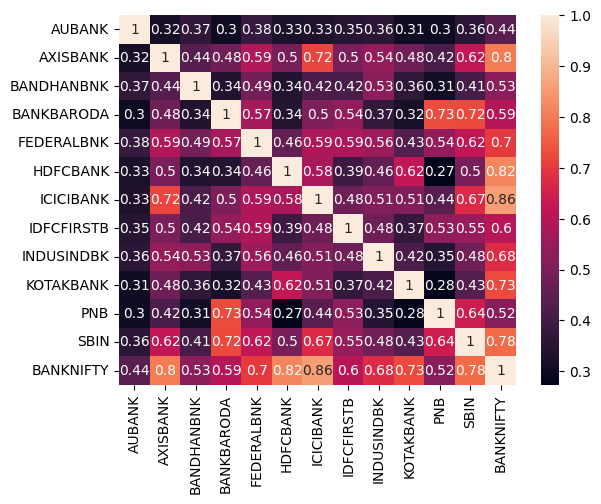

In [ ]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix,color = "red",annot=True)

In [ ]:
eigen_val,eigen_vec = np.linalg.eig(df.loc[:,'AUBANK':'SBIN'].corr())
eigen_val = list(eigen_val)

In [ ]:
np.sort(eigen_val)[::-1]

array([6.15080681, 1.20763886, 0.88313029, 0.72172426, 0.5659674 ,
       0.50724958, 0.43809685, 0.38007015, 0.37264624, 0.28257453,
       0.26491324, 0.22518181])

(0.0, 0.7)

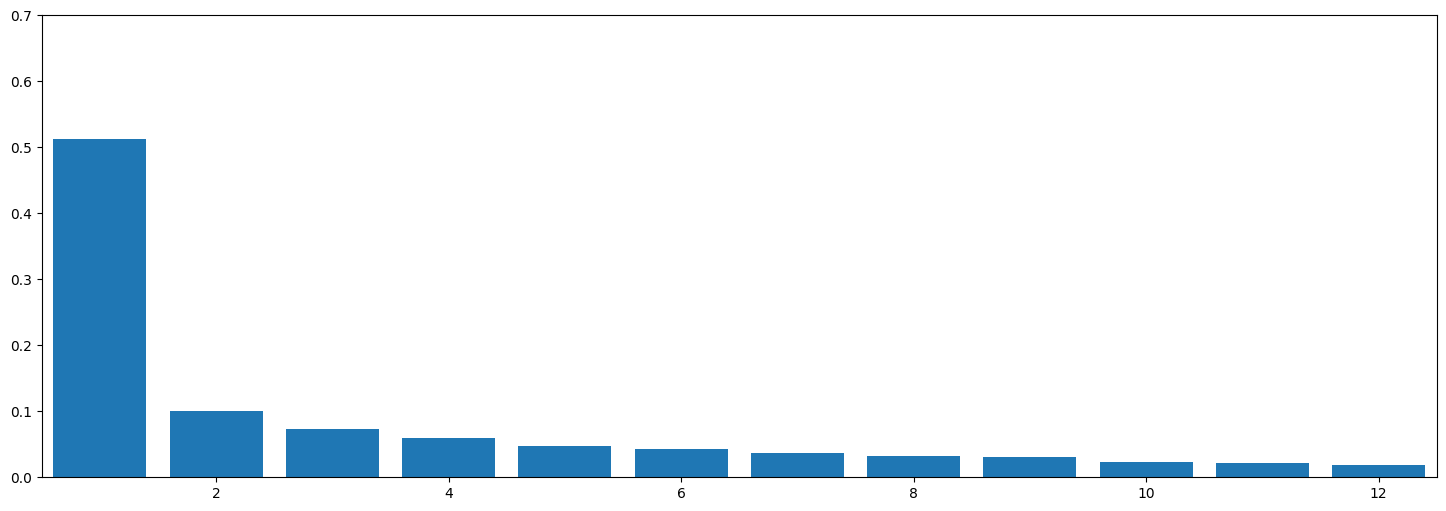

In [ ]:
plt.figure(figsize=(18,6))
plt.bar(np.arange(1,13),height = (np.sort(eigen_val)[::-1])/sum(eigen_val))
plt.xlim(0.5,12.5)
plt.ylim(0,0.7)

In [ ]:
weights = eigen_vec[:,eigen_val.index(max(eigen_val))]/df.loc[:,'AUBANK':'SBIN'].std()
weights = weights/weights.sum()

In [ ]:
ret_eig = np.cumprod((weights*df.loc[:,'AUBANK':'SBIN']).sum(axis=1)+1)
ret_index = np.cumprod(df.loc[:,'BANKNIFTY']+1)

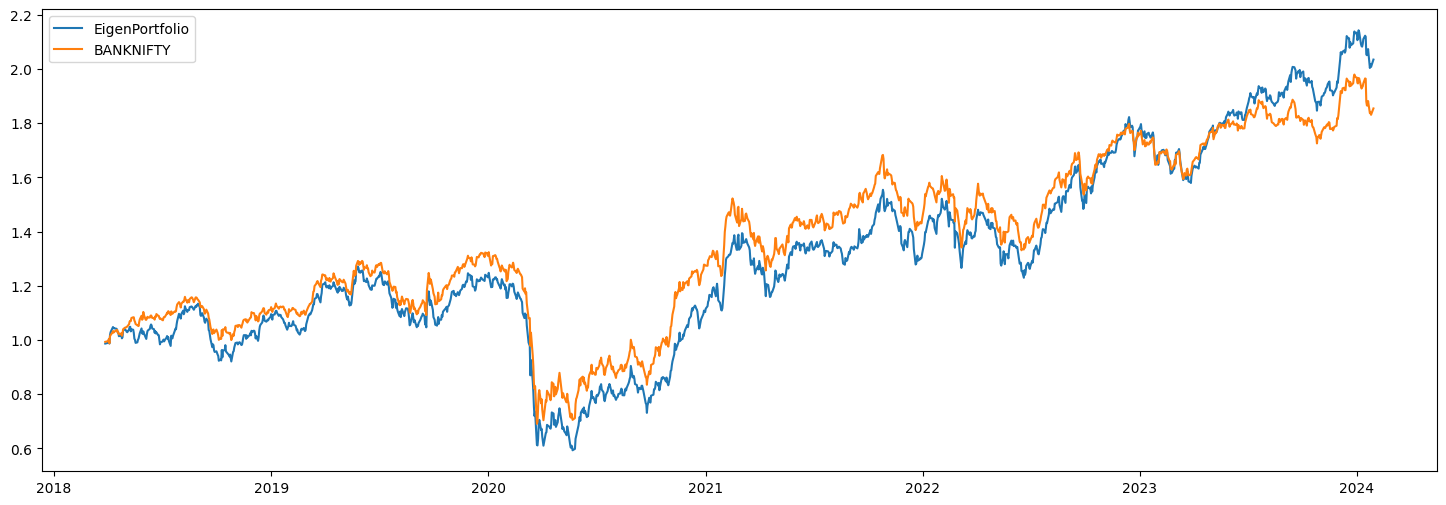

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(ret_eig,label='EigenPortfolio')
plt.plot(ret_index,label = 'BANKNIFTY')
plt.legend()

In [ ]:
#fraction of variance explained by top n PCs
def percentage_of_variance(returns,window,n):
  explained_variance = []
  for t,dt in enumerate(returns.iloc[window-1:].index):
    tmp_ret = returns.loc[:dt]
    tmp_ret = tmp_ret.iloc[-window:]
    evals = np.linalg.eig(tmp_ret.corr())[0]
    evals = np.sort(evals)[::-1]
    explained_variance.append(evals[:n].sum()/evals.sum())
  plt.figure(figsize=(18,6))
  plt.plot(explained_variance,label = 'Fraction of variance explained by 1st PC')
  plt.legend()

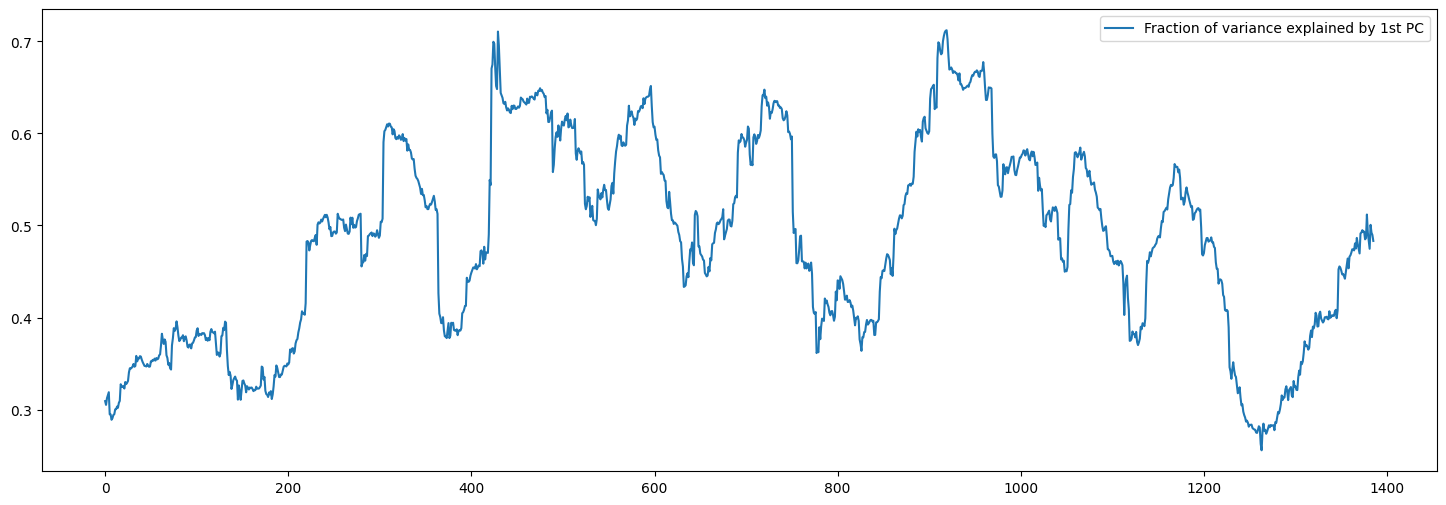

In [ ]:
#fraction of variance explained by 1st PC
percentage_of_variance(df.loc[:,'AUBANK':'SBIN'],60,1)

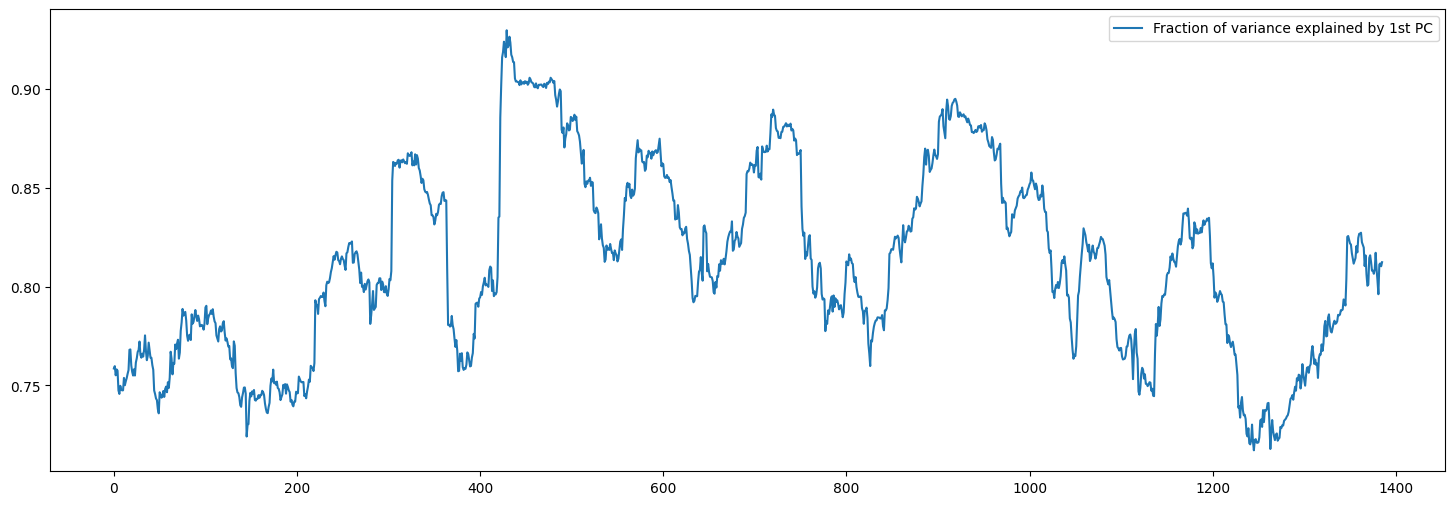

In [ ]:
#fraction_of_variance explained by top 5 PCs
percentage_of_variance(df.loc[:,'AUBANK':'SBIN'],60,5)

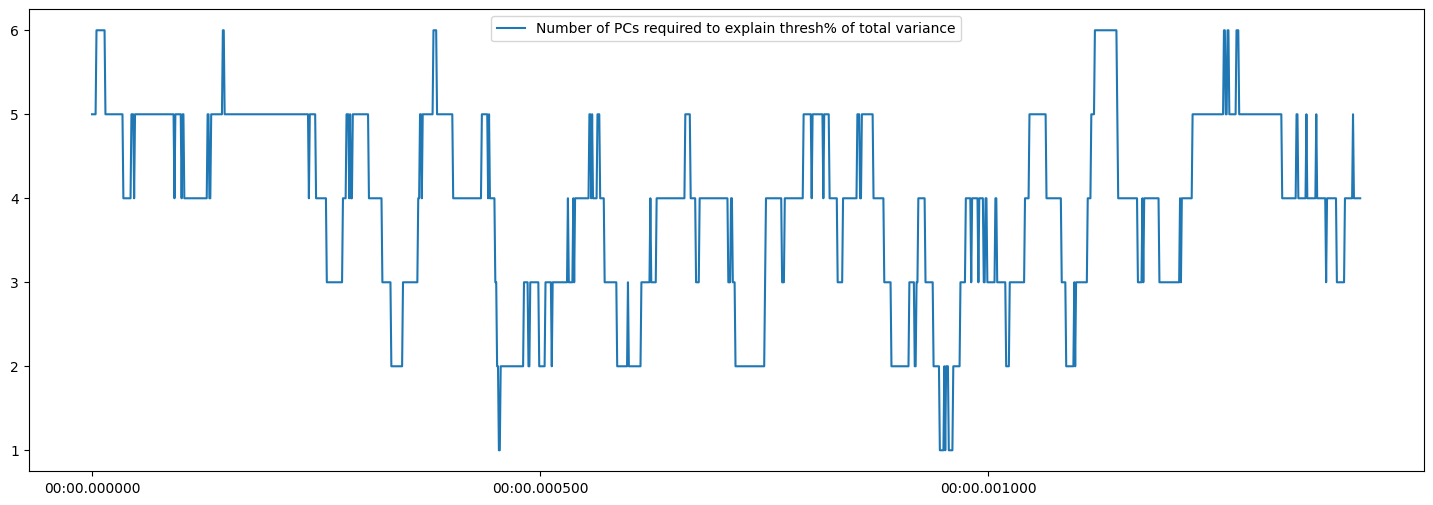

In [ ]:
#number of components required to explain at least n% of total variance
window = 30
thresh = 0.75
num_components = pd.DataFrame(index = df.index,columns = ['n_comp'])
for t,dt in enumerate(df.iloc[window-1:].index):
  tmp_ret = df.loc[:,'AUBANK':'SBIN'].loc[:dt]
  tmp_ret = tmp_ret.iloc[-window:]
  evals = np.linalg.eig(tmp_ret.corr())[0]
  evals = np.sort(evals)[::-1]
  explained_variance = evals/np.sum(evals)
  n_comp = np.where((np.cumsum(explained_variance))>=thresh)[0][0]+1
  num_components.loc[t] = n_comp
plt.figure(figsize = (18,6))
plt.plot(num_components,label = 'Number of PCs required to explain thresh% of total variance')
plt.legend()


In [ ]:
df[['eig1','eig2','eig3','eig4','eig5','eig6']] = np.nan
for t,dt in enumerate(df.iloc[59:].index):
  tmp_ret = df.loc[:,'AUBANK':'SBIN'].loc[:dt]
  tmp_ret = tmp_ret.iloc[-60:]
  evals,evecs = np.linalg.eig(tmp_ret.corr())
  index = np.argsort(evals)[::-1]

  for i in range(1,7):
    weights = evecs[:,index[i-1]]/tmp_ret.std()
    weights /= abs(weights).sum()
    df.loc[dt][f'eig{i}'] = (weights*tmp_ret.iloc[-1]).sum()

In [ ]:
df[['eig1','eig2','eig3','eig4','eig5','eig6']].corr()

,eig1,eig2,eig3,eig4,eig5,eig6
eig1,1.000000,0.072978,0.076575,-0.008857,-0.050011,0.058406
eig2,0.072978,1.000000,0.053695,-0.088942,-0.000882,-0.058967
eig3,0.076575,0.053695,1.000000,-0.002694,-0.001994,-0.017646
eig4,-0.008857,-0.088942,-0.002694,1.000000,0.047063,-0.006990
eig5,-0.050011,-0.000882,-0.001994,0.047063,1.000000,0.013106
eig6,0.058406,-0.058967,-0.017646,-0.006990,0.013106,1.000000


In [34]:
#implementing PCA portfolio
def n_pca_portfolio(returns,num_pc,l_win,s_win):
  stocks = returns.columns.drop(['BANKNIFTY','eig1','eig2','eig3','eig4','eig5','eig6'])
  print(stocks)
  s_scores = pd.DataFrame(index = returns.iloc[l_win:].index,columns = stocks)
  betas = pd.DataFrame(index = returns.iloc[l_win:].index,columns = stocks)
  pcs = ['eig1','eig2','eig3','eig4','eig5','eig6']
  for t in returns.index[l_win:]:
    tmp_ret = returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-s_win:]
    tmp_ret = (tmp_ret - tmp_ret.mean())/tmp_ret.std()
    #print(tmp_ret)
    ou_params = pd.DataFrame(index=stocks,columns = ['a','b','Var(zeta)','kappa','m',
                                                              'sigma','sigma_eq','m_bar','s'])
    for stock in stocks:
      X = tmp_ret[pcs[:num_pc]].values
      y = tmp_ret[stock]
      model1 = LinearRegression().fit(X,y)
      betas.loc[t,stock] = model1.coef_
      epsilon = y-model1.predict(X)

      #second regression
      Xk = epsilon.cumsum()
      X = np.array(Xk[:-1]).reshape(-1,1)
      y = Xk[1:]
      model2 = LinearRegression().fit(X,y)
      a = model2.intercept_
      b = model2.coef_
      #print(b)
      zeta = y - model2.predict(X)

      #OU parameters
      kappa = -np.log(b)*252
      m = a/(1-b)
      sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
      sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

      #if the speed of mean reversion is high enough, save the calulated parameters
      if kappa>252/30:
          #print(ou_params.columns)
          ou_params.loc[stock] = [a,b,np.var(zeta),kappa,m,sigma,sigma_eq,None,None]
      ou_params.dropna(axis=0,inplace = True)

      #calculate s-score
      ou_params['m_bar'] = (ou_params['a']/(1-ou_params['b']) - ou_params['a'].mean()/(1-ou_params['b'].mean()))
      ou_params['s'] = -ou_params['m_bar']/ou_params['sigma_eq']
      s_scores.loc[t] = ou_params['s']
  print(ou_params)
  #calculate positions
  algo_pos = pd.DataFrame(index = s_scores.index[1:],columns=stocks)
  for s in stocks:
    positions = pd.DataFrame(index=s_scores.index,columns=[s])
    pos = 0
    for t in s_scores.index:
      score = s_scores.loc[t][s]
      if score>1.25:
        positions.loc[t][s] = -1 #open short
        pos = -1
      elif score<-1.25:
        positions.loc[t][s] = 1#open long
        pos = 1
      elif score<0.75 and pos==1:
        positions.loc[t][s] = 0 #close short
        pos = 0
      elif score>-0.5 and pos==1:
        positions.loc[t][s] = 0 #close long
        pos = 0
      else:
        positions.loc[t][s] = pos #carry forward current position
    algo_pos[s] = positions
  print(algo_pos)
  #calculate weights(allocate equal amount of capital to long/short positions)
  algo_weights = pd.DataFrame(index = algo_pos.index,columns = stocks)
  print(algo_weights)
  for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) #equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) #equal weights among short positions
    algo_weights.loc[t] = tmp

  #calculate positions in PCA portfolios
  algo_weights[pcs[:num_pc]] = (-np.stack((betas.iloc[1:,:]*algo_weights).sum(axis=1).values)).reshape(-1,1)
  print(algo_weights)
  # calculate returns
  ret = (returns.iloc[l_win+1:] * algo_weights.shift()).sum(axis=1) / (abs(algo_weights.shift()).sum(axis=1)/2)
  cumret = np.nancumprod(ret+1)

  # calculate returns of BANKNIFTY for comparison
  bbh_cumret = np.nancumprod(returns.loc[ret.index]['BANKNIFTY']+1)
  plt.figure(figsize=(18,6))
  plt.plot(cumret, label='Algo')
  plt.plot(bbh_cumret/bbh_cumret[0], label='BANKNIFTY')
  plt.legend()

In [35]:
n_pca_portfolio(df,1,118,60)

Index(['AUBANK', 'AXISBANK', 'BANDHANBNK', 'BANKBARODA', 'FEDERALBNK',
       'HDFCBANK', 'ICICIBANK', 'IDFCFIRSTB', 'INDUSINDBK', 'KOTAKBANK', 'PNB',
       'SBIN'],
      dtype='object')
Empty DataFrame
Columns: [a, b, Var(zeta), kappa, m, sigma, sigma_eq, m_bar, s]
Index: []
           AUBANK AXISBANK BANDHANBNK BANKBARODA FEDERALBNK HDFCBANK  \
Date                                                                   
2018-09-19      0        0          0          0          0        0   
2018-09-21      0        0          0          0          0        0   
2018-09-24      0        0          0          0          0        0   
2018-09-25      0        0          0          0          0        0   
2018-09-26      0        0          0          0          0        0   
...           ...      ...        ...        ...        ...      ...   
2024-01-20      0        0          0          0          0        0   
2024-01-23      0        0          0          0          0        0   
2

TypeError: bad operand type for abs(): 'NoneType'